In [22]:
import geopandas as gpd
from glob import glob
import matplotlib.pyplot as plt
import os
import xarray as xr

In [21]:
files = glob('../data/id1_*/*.tiff')
line = glob('../data/id1_*/*.geojson')
line = gpd.read_file(line[0])

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

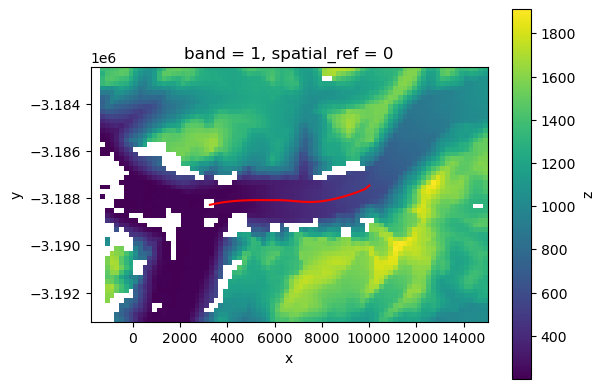

In [23]:
fig, ax = plt.subplots()
for f in files[0:1]:
    with xr.open_dataarray(f, chunks='auto') as ds:
        coarse = ds.squeeze().coarsen({'x':100, 'y':100}, boundary='trim').median()
        coarse.plot(ax=ax)
line.plot(ax=ax, color='r')

In [13]:
ds.squeeze()

<xarray.DataArray 'band_data' (y: 5429, x: 8416)> Size: 183MB
dask.array<getitem, shape=(5429, 8416), dtype=float32, chunksize=(3986, 8416), chunktype=numpy.ndarray>
Coordinates:
    band         int64 8B 1
  * x            (x) float64 67kB -1.783e+03 -1.781e+03 ... 1.504e+04 1.505e+04
  * y            (y) float64 43kB -3.182e+06 -3.182e+06 ... -3.193e+06
    spatial_ref  int64 8B ...
Attributes: (12/39)
    acqdate1:                      2012-07-25 14:57:35
    acqdate2:                      2012-07-25 14:56:17
    AREA_OR_POINT:                 Area
    avg_convergence_angle:         40.067831
    avg_expected_height_accuracy:  0.974892
    avg_sun_elev1:                 48.125
    ...                            ...
    valid_area_matchtag_density:   0.975471
    valid_area_percent:            0.7278
    valid_area_sqkm:               1104.630968
    water_area_percent:            0.251312
    water_area_sqkm:               381.432716
    long_name:                     z

In [8]:
lines = gpd.read_file('../data/streams_v2.geojson').to_crs(3413)
catalog = gpd.read_parquet(glob('../data/**/*.parquet', recursive=True)[0]).to_crs(lines.crs)

In [14]:
type(catalog)

geopandas.geodataframe.GeoDataFrame

In [42]:
line_geom = lines.loc[0,'geometry']

In [45]:
[row.Index for row in catalog.head(3).itertuples()]

[0, 1, 2]

In [32]:
geom = asdf.pop('geom')

In [35]:
geom.wkt

'MULTIPOLYGON (((-3486194.000000225 152940.00000001016, -3486194.000000225 152940.00000001016, -3486194.000000225 152940.00000001016, -3486194.000000225 152558.00000001033, -3486186.0000002254 152550.00000001013, -3486122.0000002254 152534.0000000088, -3485962.0000002244 152518.00000000917, -3485250.0000002244 152478.00000001088, -3484994.0000002235 152470.00000001144, -3484562.000000222 152462.00000001042, -3484292.0000002244 152462.0000000097, -3484284.000000223 152470.0000000107, -3484268.000000223 152502.00000001065, -3484212.0000002235 152654.00000000885, -3484196.000000224 152726.0000000118, -3482646.000000223 162108.00000000963, -3482406.0000002235 163620.00000001, -3481534.0000002235 169202.0000000125, -3481182.000000222 171522.00000001202, -3481134.000000224 171914.00000001027, -3481118.000000222 172066.00000001112, -3481118.000000222 172192.00000001147, -3481126.0000002226 172208.0000000109, -3481134.000000224 172216.000000011, -3481174.000000223 172232.00000001027, -3481286.

In [37]:
demlist = []
count = 0
for line in lines.itertuples():
    envelope = line.geometry.buffer(5000).envelope
    selection = catalog.loc[catalog.intersects(envelope)]
    print(len(selection))
    count += len(selection)
    demlist += (selection['dem_id'].tolist())
    # fig, ax = plt.subplots()
    # lines.plot(ax=ax)
    # ax.plot(*line.geometry.coords.xy, c='r')
    # selection.plot(ax=ax, fc='None')
print(f'total: {count}')

108
94
94
151
117
123
95
92
total: 874


In [39]:
len(set(demlist))

287

TODO
jason briner - long term perspectives of greenland ice sheet position
- if current approx margin configuration is where it _generally_ is during interglacials then it would *make sense* that there are lots of overdeepenings just up-ice.
- Lindbäck, K., R. Pettersson, A. L. Hubbard, S. H. Doyle, D. van As, A. B. Mikkelsen, and A. A. Fitzpatrick. 2015. Subglacial water drainage, storage and piracy beneath the Greenland ice sheet. Geophysical Research Letters 42:7606–14.
see lindback references in ross et al., 2018
- Lindbäck, K., R. Petterson, S. H. Doyle, C. Helanow, P. Jansson, S. S. Kristensen, L. Stenseng, R. Forsberg, and A. L. Hubbard. 2014. High-resolution ice thickness and bed topography of a land-terminating section of the Greenland ice sheet. Earth System Science Data 6:331–38.
is there evidence of *preferential* erosion signature

lake massu
simon mudd, mikael attal - what are lakes? 
rivers **cannot** erode below base level.

TODO
send PN velocity figures and summary paragraph

In [1]:
from dask.distributed import Client, LocalCluster
import pandas as pd
# import itslive
import geopandas as gpd
# from shapely.geometry import Polygon
# from shapely import box
import matplotlib.pyplot as plt
# from matplotlib.collections import LineCollection
# from matplotlib.dates import date2num, DateFormatter, YearLocator
# import seaborn as sns
# import xrspatial as xrs
import numpy as np
import xarray as xr
from tqdm import tqdm
from IPython import display
import importlib
# import imagery
import utils
import velocity_helpers

In [2]:
# _ = importlib.reload(utils)
# _ = importlib.reload(velocity_helpers)
# _ = importlib.reload(imagery)

In [2]:
cluster = LocalCluster()
client = Client(cluster)
print(client.dashboard_link)

http://127.0.0.1:8787/status


In [5]:
## read in lines, and lazily get velocity cubes, centrelines, and robust trends
lines = gpd.read_file('../data/streams_v2.geojson').to_crs(3413)

In [6]:
V = {}
failed = []
for row in tqdm(lines.sample(3).itertuples()):
    print(f'working on #{row.Index}')
    try:
        V[row.Index] = velocity_helpers.CentreLiner(
            geo=row.geometry,
            buff_dist=500,
            index=row.Index,
            filter_cube=False,
            get_robust_trend=True,
            get_annual_median=False,
            get_rgb=False,
            )
    except Exception as e:
        failed.append((row.Index, e))
        print(f'#{row.Index} did not work because\n{e}')
        continue

0it [00:00, ?it/s]

working on #1
getting cubes from itslive
computing spatial trends


1it [00:11, 11.24s/it]

trends lazily computed, adding metadata: 240530_1359
working on #3
getting cubes from itslive
computing spatial trends


2it [00:18,  9.14s/it]

trends lazily computed, adding metadata: 240530_1359
working on #11
getting cubes from itslive
computing spatial trends


3it [00:27,  9.25s/it]

trends lazily computed, adding metadata: 240530_1359


In [13]:
import importlib

In [33]:
_ = importlib.reload(utils)

In [28]:
import utils

In [ ]:
utils.Tools.shapely_reprojector()

In [2]:
from shapely import Point, Polygon, LineString
import geopandas as gpd

In [34]:
ls = LineString([[0, 0], [100_000, 100_000]])

In [35]:
newls = utils.Tools.shapely_reprojector(ls, 27700, 4326)

In [24]:
gpd.GeoDataFrame(geometry=[newls], crs=4326).explore()

In [13]:
asdf = V[11].export_trend()

## other

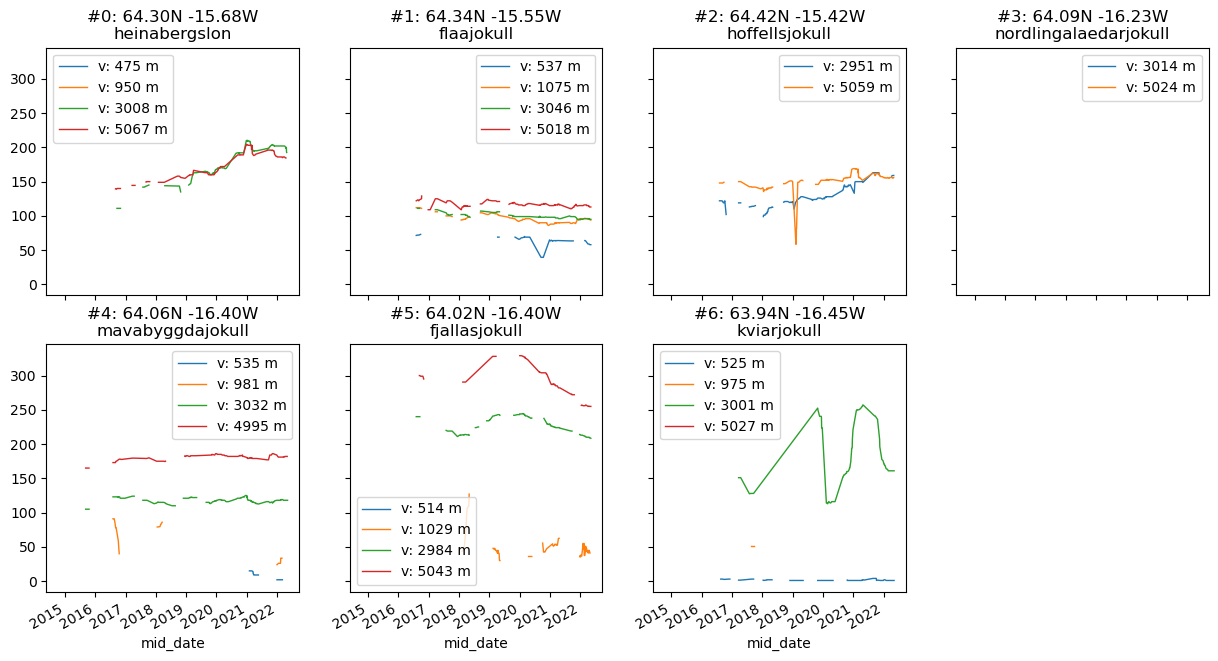

In [24]:
fig, axs = plt.subplots(figsize=[15,8],
                        nrows=2,
                        ncols=4,
                        sharex=True,
                        sharey=True)

for k_v, ax in zip(V.items(), axs.flat):
    k, v = k_v
    velocity_helpers.Plotters.rolling_median(v,
                                             ax=ax,
                                         **{'var': 'v',
                                            'ddt_range': ('335d','395d'),
                                            'ddt_bars': False,
                                            'col': 'cumul_dist',
                                            'window': '90d',
                                            'vals':[500, 1_000, 3_000, 5_000]
                                            })
    _point = utils.shapely_reprojector(v.point, 3413, 4326)
    
    ax.set_title(f'#{k}: {_point.y:.2f}N {_point.x:.2f}W\n{lines.loc[k,"name"]}')
    ax.minorticks_off()

# axs.flat[-2].remove()
axs.flat[-1].remove()

now = pd.Timestamp.now().strftime('%y%m%d_%H%M')+ '_'
directory = '../../GitHub/diary/journal_figures'
filename = 'iceland_outlets_annual_v.png'
fig.savefig(directory + now + filename, bbox_inches = 'tight')

In [ ]:
def centreline_theil_slopes(df, **kwargs):
    
    _var = kwargs.get('var', 'v')
    _x = kwargs.get('x', 'mid_date')
    _date_range = kwargs.get('date_range', (pd.Timestamp('1900-01-01'),
                                            pd.Timestamp.now()))
    _ddt_range = kwargs.get('ddt_range', ('0d', '30d'))
    _mad = kwargs.get('mad', 3)
    
    _df = df.loc[df[_x].between(*_date_range)]    

In [ ]:
idx = ((ds['date_dt'] > pd.Timedelta('335d')) & ((ds['date_dt'] <= pd.Timedelta('395d')))).compute()

from scipy.stats.mstats import theilslopes
from scipy.stats import linregress

x = (ds.mid_date[idx] - ds.mid_date[idx].min()) / pd.Timedelta('365.25d')
y = ds['v'][idx,50,50].compute()

nan_idx = y.isnull()

x = x[~nan_idx]
y= y[~nan_idx]

theil_result = theilslopes(y=y, x=x)
lr_result = linregress(x=x, y=y)


X = np.arange(0,30)
theil_fit = (X * theil_result.slope) + theil_result.intercept
lr_fit = (X * lr_result.slope) + lr_result.intercept

fig, ax = plt.subplots()
ax.scatter(x,y)

ax.plot(X, theil_fit, c='r', label='theilslopes')
ax.plot(X, lr_fit, c='g', label='lr')
ax.legend()

In [ ]:
fig, axs = plt.subplots(figsize=[15,8], nrows=5, ncols=3)
# get_velocity.Plotters.date_dt_bars(V[13],
#                                    ('1d','15d'),
#                                    ax=ax,
#                                    **{'vals':[5_000,1_000]})

get_velocity.Plotters.rolling_median(V[13],
                                     ('335d','395d'),
                                     ax=ax,
                                     ddt_bars=False,
                                     **{'var': 'v',
                                        'col': 'cumul_dist',
                                        'window': '180d',
                                        'vals':[1_000, 3_000, 5_000, 10_000]})

- look at underlying dodgy velocity images
TODO look at GRIMpP and MEASUREs

TODO
- PN thinks that relative change is sufficient to *control* for variations in glacier geometry (read: width/size).
- most interested in *relative* change of velocity over final few kilometers.
    - i.e. 

- it all comes from the same raw processed v data

## imagery

In [ ]:
study_sites = gpd.read_file('../data/potential_study_sites_v1.geojson')
study_sites = study_sites.loc[study_sites['notes'].isin(['yes', 'maybe'])]
study_sites.reset_index(drop=True, inplace=True)
study_sites_5k = study_sites.buffer(5_000).to_crs(4326)

In [ ]:
items = imagery.get_annual_median_mosaic(
    study_sites.loc[0,'geometry'],
    buffer_dist=15_000,
    src_crs=study_sites.crs,
    target_crs=4326,
    timeperiod='2023-01-01/2024-01-01',
    months=[8,9],
    )

In [ ]:
(xrs.multispectral.true_color(
    *items.squeeze()
    .transpose('band', 'y', 'x'))
 .plot.imshow(rgb='band')
)

In [ ]:
import stackstac
stackstac.stack(items, assets=['B04', 'B03', 'B02'])